Идея A/B тестирования: Пользователи ресурса случайным образом делятся на сегменты. Один из сегментов остается без изменений — это контрольный сегмент “A”, на основе данных по этому сегменту мы будем оценивать эффект от вносимых изменений. Пользователям из сегмента “B” показываем измененную версию ресурса.

- каждый пользователь относится только к одному сегменту, чтобы исключить влияние сегментов друг на друга и получить статистически правильный результат

- замеры в сегментах проводятся параллельно, т.е. в один и тот же период времени, для снижения влияния внешних факторов, таких как рекламные кампании, день недели, погода или сезонность


**Входные данные:**

**orders.csv** - информация о заказах пользователей в интернет-магазине
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.



**visitors.csv** - информация о посещениях пользователями интернет-магазина
- date — дата;
- group — группа A/B-теста;
-visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

Задача: Провести анализ результатов проведенного А/В-тестирования и сделать выводы о победе одной из групп или об отсутствии различий между группами.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt

In [62]:
pd.options.display.float_format = '{:,.4f}'.format

In [63]:
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

# Обзор данных

In [64]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders.shape

(1197, 5)

In [4]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
visitors.shape

(62, 3)

In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


# Предобработка данных

In [65]:
# изменим тип данных у столбцов с датами
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [66]:
# переименуем стоблцы с Id на _id
orders.columns = map(lambda row: row.replace('Id', '_id'), orders.columns)
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [11]:
# посмотрим на количество дубликатов
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


# A/B тестирование

Собираем агрегированный датафрейм, содержащий информацию:
- дата
- группа
- количество заказов в данный день от группы
- количество пользователей в данный день от группы
- выручка в данный день от группы

In [67]:
orders_grouped = orders.groupby(['date','group'], as_index=False).agg({
    'transaction_id':'count',
    'visitor_id':'nunique',
    'revenue':'sum'}).sort_values(['date','group'])
orders_grouped = orders_grouped.rename(columns={'transaction_id': 'orders', 'visitor_id': 'clients'})
orders_grouped

,date,group,orders,clients,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,20,19,93822
3,2019-08-02,B,24,23,165531
4,2019-08-03,A,24,24,112473
...,...,...,...,...,...
57,2019-08-29,B,20,20,231130
58,2019-08-30,A,11,10,86460
59,2019-08-30,B,24,24,215233
60,2019-08-31,A,12,12,61833


Собираем агрегированный датафрейм, содержащий информацию:
- дата
- группа
- количество посещений в данный день от группы

In [68]:
visitors_grouped = visitors.groupby(['date','group'], as_index=False).agg({
'visitors': 'sum'}).sort_values(['date','group'])
visitors_grouped

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,619
3,2019-08-02,B,581
4,2019-08-03,A,507
...,...,...,...
57,2019-08-29,B,531
58,2019-08-30,A,490
59,2019-08-30,B,490
60,2019-08-31,A,699


Посчитаем коммулятивные суммы

In [69]:
orders_cumsum = orders_grouped
# скопируем group чтобы провести по ней кумулятивную сумму
orders_cumsum['group_copy'] = orders_cumsum['group']
orders_cumsum = orders_cumsum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index()
orders_cumsum

,date,group,orders,clients,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,39,242401
3,2019-08-02,B,45,43,266748
4,2019-08-03,A,68,63,354874
...,...,...,...,...,...
57,2019-08-29,B,596,584,5559398
58,2019-08-30,A,545,531,4022970
59,2019-08-30,B,620,608,5774631
60,2019-08-31,A,557,543,4084803


In [70]:
visitors_cumsum = visitors_grouped
visitors_cumsum['group_copy'] = visitors_cumsum['group']
visitors_cumsum = visitors_cumsum.set_index(['date','group']).groupby('group_copy').cumsum().reset_index()
visitors_cumsum

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845
...,...,...,...
57,2019-08-29,B,17708
58,2019-08-30,A,18037
59,2019-08-30,B,18198
60,2019-08-31,A,18736


Объединяем кумулятивные данные в одной таблице

In [71]:
cumulative_data = orders_cumsum.merge(
    visitors_cumsum,
    left_on=['date', 'group'],
    right_on=['date', 'group']
)
cumulative_data

,date,group,orders,clients,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,39,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,63,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,584,5559398,17708
58,2019-08-30,A,545,531,4022970,18037
59,2019-08-30,B,620,608,5774631,18198
60,2019-08-31,A,557,543,4084803,18736


Добавим расчетные колонки с конверсией и средним чеком

In [72]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors'] # заказы / посещения сайта
cumulative_data['average_check'] = cumulative_data['revenue'] / cumulative_data['orders'] # выручка / количество заказов
cumulative_data.head(6)

,date,group,orders,clients,revenue,visitors,conversion,average_check
0,2019-08-01,A,24,20,148579,719,0.0334,"6,190.7917"
1,2019-08-01,B,21,20,101217,713,0.0295,"4,819.8571"
2,2019-08-02,A,44,39,242401,1338,0.0329,"5,509.1136"
3,2019-08-02,B,45,43,266748,1294,0.0348,"5,927.7333"
4,2019-08-03,A,68,63,354874,1845,0.0369,"5,218.7353"
5,2019-08-03,B,61,59,380996,1803,0.0338,"6,245.8361"


**График кумулятивной выручки по группам**

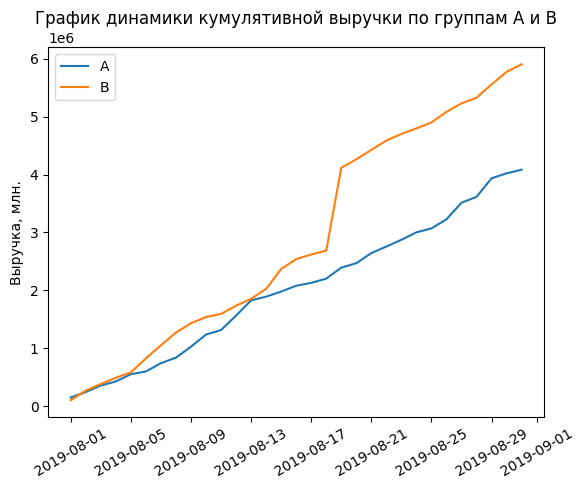

In [73]:
cumulative_a = cumulative_data[cumulative_data['group']=='A']

cumulative_b= cumulative_data[cumulative_data['group']=='B']

plt.plot(cumulative_a['date'], cumulative_a['revenue'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Вывод: группа B стабильно показывает большую выручку чем группа A.

**График кумулятивного среднего чека по группам**

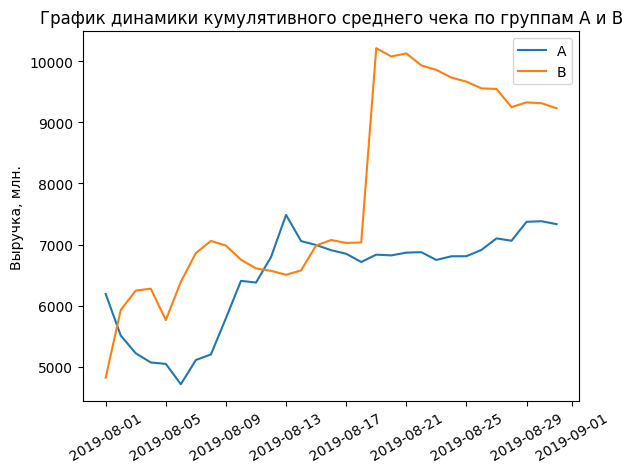

In [74]:
plt.plot(cumulative_a['date'], cumulative_a['average_check'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['average_check'], label='B')
plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Вывод: В промежутке с 17.08.2019 по 21.08.2019 средний чек группы В сделал сильный скачок вверх, затем немного снизился, возможно, произошла какая-то аномалия.

Однако, средний чек в группе B почти всё время был выше.

**График кумулятивной конверсии по группам**

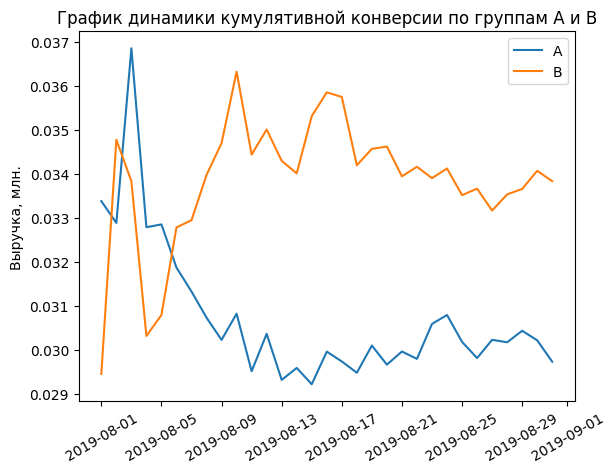

In [75]:
plt.plot(cumulative_a['date'], cumulative_a['conversion'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['conversion'], label='B')
plt.title('График динамики кумулятивной конверсии по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

Вывод: сначала конверсии колебались, затем конверсия группы B лучше, чем группы A.

**График относительного изменения кумулятивной конверсии группы B к группе A**

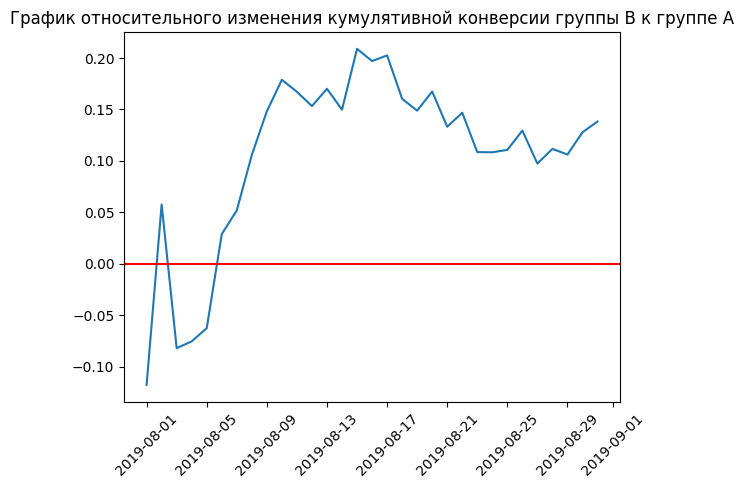

In [98]:
b_to_a = (cumulative_a[['date', 'conversion']].merge(cumulative_b[['date', 'conversion']],
                                            left_on='date', right_on='date', how='left', suffixes=['_A', '_B']))
plt.plot(b_to_a['date'], b_to_a['conversion_B'] / b_to_a['conversion_A'] - 1)
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='red', linestyle='-')
plt.xticks(rotation=45)
plt.show()

**Аномальные заказы:** заказы на большую сумму или пользователи, совершившие много заказов.

Оценим сколько заказов в среднем приходится на одного пользователя

In [76]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']
display(orders_by_users['orders'].describe())

,orders
count,"1,031.0000"
mean,1.1610
std,0.7249
min,1.0000
25%,1.0000
50%,1.0000
75%,1.0000
max,11.0000


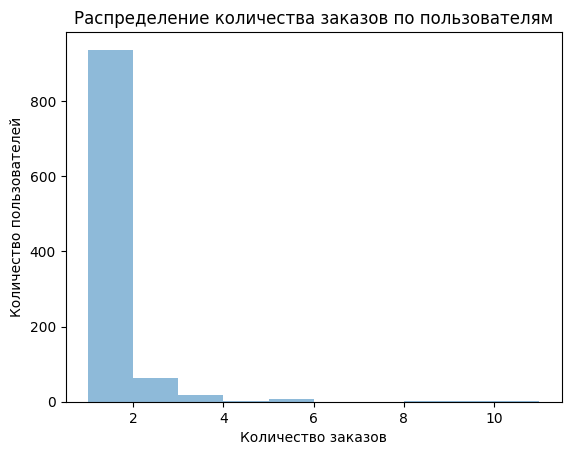

In [77]:
# строим гистограмму
plt.hist(orders_by_users['orders'], alpha=0.5)
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

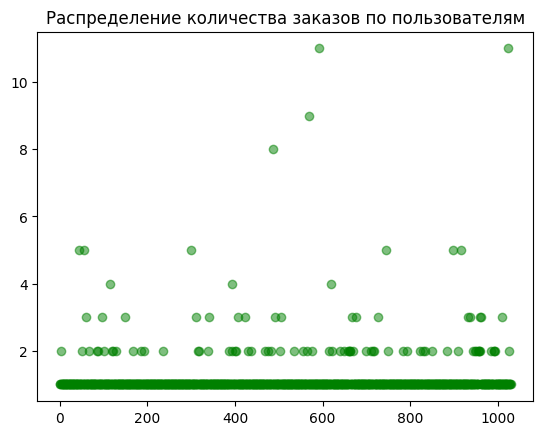

In [78]:
# строим точечную диаграмму
x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders'], color='green', alpha=0.5)
plt.title('Распределение количества заказов по пользователям')
plt.show()

Вывод-> большинство пользователей в среднем оформляют по 1 заказу, реже 2-3 заказа, но есть и те, кто оформил > 8 заказов.

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.

In [79]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

Вывод -> больше 2 заказов совершают только 5% пользователей. За верхнюю границу возьмем 99% перцентстиль.

Оценим среднюю стоимость заказа.

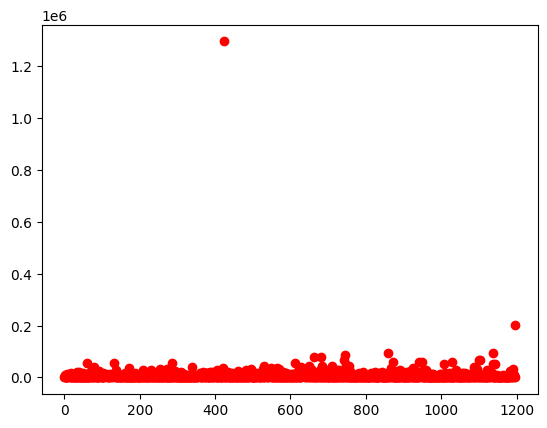

In [80]:
# строим точечную диаграмму
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='red')
plt.show()

Вывод: есть 2 сильно отличающихся заказа, это те выбросы, которые и вызвали скачки на графиках выше.

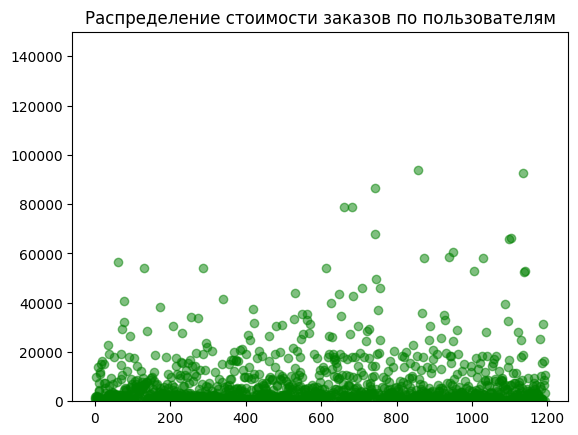

In [81]:
# строим точечную диаграмму  заказов до 150к, т.е. без двух крупных выбросов
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], color='green', alpha=0.5)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

Вывод: в основном все заказы до 40к.

Посчитаем 95-й и 99-й перцентили стоимости заказов на пользователя и выберим границу для определения аномалий.

In [27]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


За верхнюю границу возьмем 99% перцентстиль.

# Анализ статистической значимости

Cтатистическая значимость различий в конверсии между группами, «сырые» данные

Введем основную и альтернативные гипотезы:

H0 - конверсия в группе A равна конверсии в группе B

H1 - конверсия в группе A не равна конверсии в группе B

Z-тест, z-критерий Фишера



In [91]:
conversion = (orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']
conversion

,group,orders,visitors,conversion
0,A,557,18736,0.0297
1,B,640,18916,0.0338


In [83]:
from scipy import stats as st


def z_test_conversion(conversion):
    alpha=0.05
    z_orders = conversion['orders']
    z_visitors = conversion['visitors']
    p1 = z_orders[0] / z_visitors[0]
    p2 = z_orders[1] / z_visitors[1]
    combined = (z_orders[0] + z_orders[1]) / (z_visitors[0] + z_visitors[1])
    difference = p1-p2
    z_value = difference / math.sqrt(combined * (1 - combined) * (1 / z_visitors[0] + 1 / z_visitors[1]))
    distr = st.norm(0,1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

z_test_conversion(conversion)

p-значение:  0.02320723394441848
Отвергаем нулевую гипотезу


относительный прирост конверсии группы B:

конверсия группы B / конверсия группы A - 1

In [92]:
conversion.loc[1, 'conversion'] / conversion.loc[0, 'conversion'] - 1

0.13807884655320146

Относительный прирост В к А: 13.8%

Cтатистическая значимость различий в конверсии между группами по «очищенным» данным.

In [94]:
clear_clients = orders_by_users[orders_by_users['orders'] <= 4]['visitor_id']

In [95]:
clear_orders = orders[orders['visitor_id'].isin(clear_clients)]

conversion = (clear_orders.groupby('group').agg({'transaction_id':'count'}).rename(columns={'transaction_id':'orders'}))\
                                     .join((visitors.groupby('group').agg({'visitors':'sum'}))).reset_index()
conversion['conversion'] = conversion['orders'] / conversion['visitors']
conversion

,group,orders,visitors,conversion
0,A,522,18736,0.0279
1,B,606,18916,0.0320


In [96]:
z_test_conversion(conversion)

p-значение:  0.017482634695754395
Отвергаем нулевую гипотезу


In [97]:
conversion.loc[1, 'conversion'] / conversion.loc[0, 'conversion'] - 1

0.14987251563476045

Относительный прирост В к А: 14.99%

Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Введем основную и альтернативные гипотезы:

H0 - Средний чек A не превосходит средний чек группы B

H1 - Средний чек A превосходит средний чек группы B

Критерий Манна-Уитни

In [87]:
alpha = 0.05
results = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.7292909855432458
Не получилось отвергнуть H0: вывод о различии сделать нельзя


Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [89]:
orders_clear = orders[orders['revenue'] <= 58233]

In [90]:
alpha = 0.05
results = st.mannwhitneyu(orders_clear[orders_clear['group']=='A']['revenue'], orders_clear[orders_clear['group']=='B']['revenue'])
pvalue = results.pvalue
print('p-значение: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

p-значение:  0.6208626966847455
Не получилось отвергнуть H0: вывод о различии сделать нельзя


Выводы:

* Есть статистически значимое различие по конверсии между группами как по «сырым», так и по данным после фильтрации аномалий.  Конверсия группы В выше, чем в А, на 14-15%;

* Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

* График относительного изменения кумулятивной конверсии группы B к группе A показывает, что результаты группы В стабильно лучше группы А;

Что пользволяет нам сделать вывод о том, что мы можем остановить наш A/B тест и зафиксировать победу группы B.
